<a href="https://colab.research.google.com/github/kmkarakaya/ML_tutorials/blob/master/How_to_solve_Multi_Class_Classification_Problems_in_Deep_Learning_with_Tensorflow_%26_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#@title Import Dependencies
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt


---
---

---
# How to solve Multi-Class Classification Problems in Deep Learning with Tensorflow & Keras?

This is the **third part** of the "***How to solve Classification Problems in Keras?***" series.

If you have not gone over **Part A and Part B**, ***please review them*** before continue with this tutorial.

The link to all parts are provided in the video description.

In this tutorial, we will focus on how to solve **Multi-Class Classification** Problems in **Deep Learning** with **Tensorflow & Keras**.

First, we will download the MNIST dataset.

In multi-class classification problems, we have **two options** to **encode** the true **labels**  by using either:

* integer numbers, or
* one-hot vector

We will experiment with both encodings to observe the effect of the combinations of various last layer's activation functions and loss functions on a Keras CNN model's performance.


In both experiments, we will discuss the relationship between
 ***Activation & Loss functions***,  ***label encodings***, and **accuracy metrics** in details.

We will understand why sometimes we could get **suprising results** when using ***different*** parameter settings other than the generally **recommended** ones.

As a result, we will **gain insight** about activation  and loss functions and their inteactions.

**In the end**, we will summarize the experiment results in a cheat table.

If you would like to learn more about Deep Learning with practical coding examples, please **subscribe** to [my YouTube Channel](https://www.youtube.com/channel/UCrCxCxTFL2ytaDrDYrN4_eA/playlists) or **follow** [my blog on Medium](https://medium.com/@kmkarakaya). Do not forget to turn on **Notifications** so that you will be notified when ***new parts are uploaded***.

You can access this **Colab Notebook** using [the link](https://colab.research.google.com/drive/1KsNfjXyR6A_8pN4PCc0fVhLiZoY1XJPY?usp=sharing) given in the video description below.

If you are ready, let's get started!


---
# ***How to solve Classification Problems in Keras?*** 

## PARTS

[Part A : Classification in Deep Learning](https://kmkarakaya.medium.com/how-to-solve-classification-problems-in-deep-learning-with-tensorflow-keras-6e39c5b09501)

[Part B: Binary classification](https://kmkarakaya.medium.com/which-activation-loss-functions-part-a-e16f5ad6d82a) 

[Part C: Multi-Class classification](https://kmkarakaya.medium.com/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f)

Part D: Multi-Label classification 

You can access all these parts on **YouTube** in [**ENGLISH**](https://youtube.com/playlist?list=PLQflnv_s49v-RGv6jb_sFOb_of9VOEpKG) or [**TURKISH**](https://youtube.com/playlist?list=PLQflnv_s49v8xVM2mUaUfllqeUsMtfW83)

In [23]:
from IPython.lib.display import YouTubeVideo
#YouTubeVideo('cKCt7RHfuyA')

---
# References

[ Keras API reference / Losses / Probabilistic losses](https://keras.io/api/losses/probabilistic_losses/
) 

[Keras Activation Functions](https://keras.io/api/layers/activations/)

[Tensorflow Data pipeline (tf.data) guide](https://www.tensorflow.org/guide/data#using_tfdata_with_tfkeras)

[How does tensorflow sparsecategoricalcrossentropy work?](https://stackoverflow.com/questions/59787897/how-does-tensorflow-sparsecategoricalcrossentropy-work)


[Cross-entropy vs sparse-cross-entropy: when to use one over the other](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other)

[Why binary_crossentropy and categorical_crossentropy give different performances for the same problem?](https://stackoverflow.com/questions/42081257/why-binary-crossentropy-and-categorical-crossentropy-give-different-performances)

---
# Load a Multi-Label Dataset
I pick the MNIST dataset a famous multi label dataset

First let's load the MNIST dataset from [Tensorflow Datasets](https://www.tensorflow.org/datasets)

In [24]:
[ds_raw_train, ds_raw_test], info = tfds.load('mnist', 
                                      split=['train[:10%]','test[:10%]'], as_supervised=True, with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Check the number of samples in Train and Test datasets

In [25]:
print("Number of samples in train : ", ds_raw_train.cardinality().numpy(),
      " in test : ",ds_raw_test.cardinality().numpy())

Number of samples in train :  6000  in test :  1000


Observe the information about labels

In [26]:
print("Number of classes/labels: ",info.features["label"].num_classes)
print("Names of classes/labels: ",info.features["label"].names)

labels= info.features["label"].names

Number of classes/labels:  10
Names of classes/labels:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


See some sample images (data) with their true labels

9 samples from the dataset


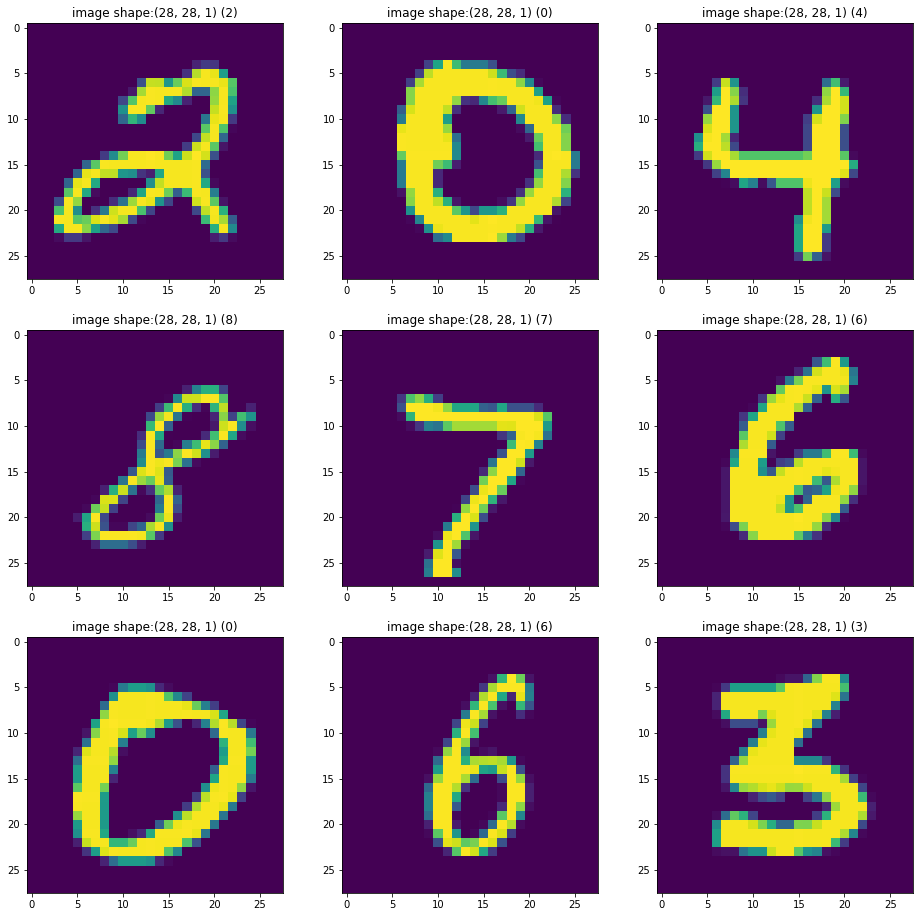

In [27]:
def show_samples(dataset):
  fig=plt.figure(figsize=(16, 16))
  columns = 3
  rows = 3
  
  print(columns*rows,"samples from the dataset")
  i=1
  for a,b in dataset.take(columns*rows): 
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(a))
    #plt.imshow(a.numpy())
    plt.title("image shape:"+ str(a.shape)+" ("+str(b.numpy()) +")" )

    i=i+1
  plt.show()
show_samples(ds_raw_test)

Notice that:**
* There are **10 classes** 
* For each sample, there is a **single integer value per class** 



### Let's resize and scale the images so that we can save time in training

In [28]:
#VGG16 expects min 32 x 32 
def resize_scale_image(image, label):
  image = tf.image.resize(image, [32, 32])
  image = image/255.0
  image = tf.image.grayscale_to_rgb(image)
  return image, label

9 samples from the dataset


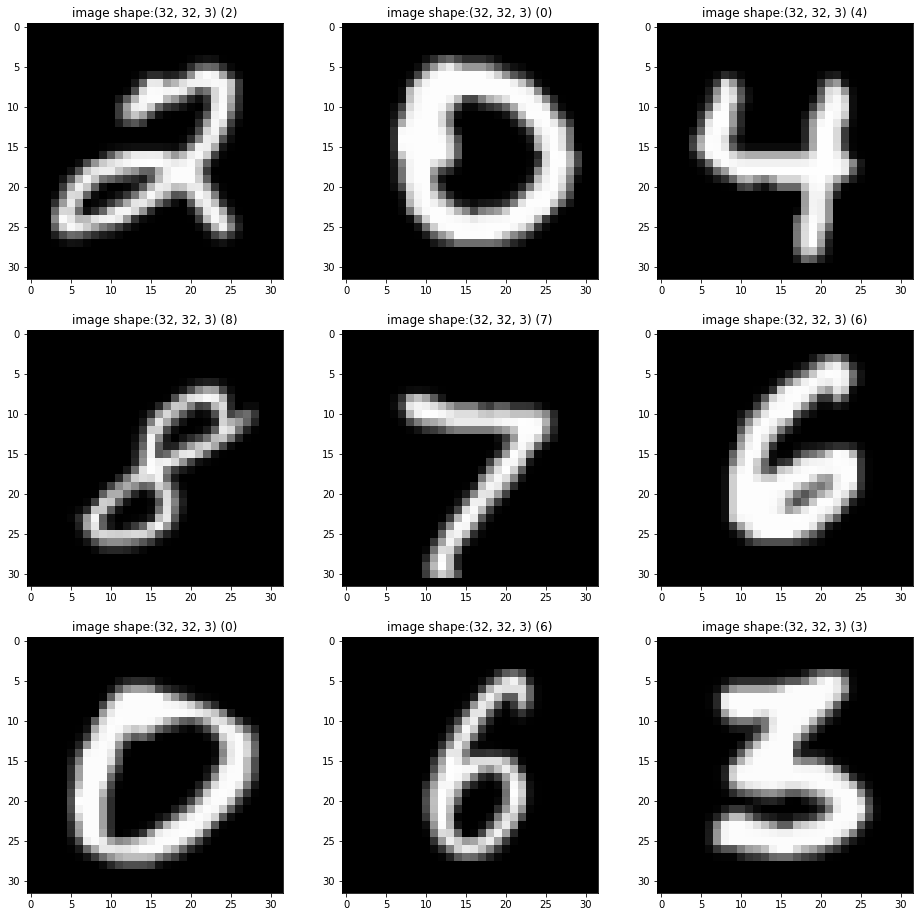

In [29]:
ds_train_resize_scale=ds_raw_train.map(resize_scale_image)
ds_test_resize_scale=ds_raw_test.map(resize_scale_image)
show_samples(ds_test_resize_scale)

### Prepare the data pipeline by setting batch size & buffer size using [tf.data](https://www.tensorflow.org/guide/data)

In [30]:
batch_size = 64 

ds_train_resize_scale_batched=ds_train_resize_scale.batch(batch_size, drop_remainder=True ).cache().prefetch(tf.data.experimental.AUTOTUNE)
ds_test_resize_scale_batched=ds_test_resize_scale.batch(batch_size, drop_remainder=True ).cache().prefetch(tf.data.experimental.AUTOTUNE)

print("Number of batches in train: ", ds_train_resize_scale_batched.cardinality().numpy())
print("Number of batches in test: ", ds_test_resize_scale_batched.cardinality().numpy())


Number of batches in train:  93
Number of batches in test:  15


### To train fast, let's use Transfer Learning by importing VGG16

In [31]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(32, 32, 3), # VGG16 expects min 32 x 32
    include_top=False)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


# 1. True (Actual) Labels are encoded with a **single integer number** 

### Create the classification model


In [32]:
number_of_classes = 10

In [33]:
inputs = keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)

activation =  None  # tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
model = keras.Model(inputs, outputs)

**Pay attention**:
* The last layer has 10 (***number_of_classes***) unit. So the output (***y_pred***)  will be **10 floating points** as the true (actual) label (***y_true***) is **a single integer number**!

* For the last layer, the activation function can be:
  * None 
  * sigmoid 
  * softmax
* When there is **no activation** function is used in the model's last layer, we need to set `from_logits=True` **in cross-entropy loss functions** as we discussed above. Thus, **cross-entropy loss functions** will apply a **sigmoid** transformation on **predicted label values**:

  `if from_logits: return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)`


### Compile the model

In [34]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

**IMPORTANT:** We need to use **keras.metrics.SparseCategoricalAccuracy()** for **measuring** **the** **accuracy** since it calculates how often predictions match **integer labels**.


* As we mentioned above, Keras does ***not*** define a ***single*** accuracy metric, but ***several*** different ones, among them: `accuracy`, `binary_accuracy` and `categorical_accuracy`. 
* What happens under the hood is that, if you select ***mistakenly*** **categorical cross entropy as your loss function** in a **binary classification** and if you do ***not specify*** a particular accuracy metric by just writing
 
 `metrics="Accuracy"`

  Keras (***wrongly***...) **infers** that you are interested in the **categorical_accuracy**, and this is what it returns - while in fact you are interested in the **binary_accuracy** since our problem is a binary classification.

In summary; 
* to get `model.fit()` and `model.evaulate()` run correctly (without mixing the loss function and the classification problem at hand) we need to **specify the actual accuracy metric**!
* if the true (actual) labels are encoded with integer numbers, you need to use **keras.metrics.SparseCategoricalAccuracy()** for **measuring** **the** **accuracy** since it calculates how often how often predictions match **integer labels**.

### Try & See
Now, we can try and see the performance of the model by using **combination of activation  and loss functions.**

In [35]:
model.fit(ds_train_resize_scale_batched, validation_data=ds_test_resize_scale_batched, epochs=40)

Epoch 1/40
93/93 [==============================] - 9s 19ms/step - loss: 2.1491 - sparse_categorical_accuracy: 0.2820 - val_loss: 1.3679 - val_sparse_categorical_accuracy: 0.6927
Epoch 2/40
93/93 [==============================] - 1s 12ms/step - loss: 1.2638 - sparse_categorical_accuracy: 0.7162 - val_loss: 1.0034 - val_sparse_categorical_accuracy: 0.7708
Epoch 3/40
93/93 [==============================] - 1s 11ms/step - loss: 0.9503 - sparse_categorical_accuracy: 0.7840 - val_loss: 0.8234 - val_sparse_categorical_accuracy: 0.8177
Epoch 4/40
93/93 [==============================] - 1s 12ms/step - loss: 0.7871 - sparse_categorical_accuracy: 0.8231 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/40
93/93 [==============================] - 1s 12ms/step - loss: 0.6835 - sparse_categorical_accuracy: 0.8425 - val_loss: 0.6332 - val_sparse_categorical_accuracy: 0.8667
Epoch 6/40
93/93 [==============================] - 1s 11ms/step - loss: 0.6099 - sparse_categorical_accu

In [36]:
ds= ds_test_resize_scale
print("Test Accuracy: ", model.evaluate(ds.batch(batch_size=10))[1])
predictions= model.predict(ds.batch(batch_size=10).take(1))
y=[]
print("10 Sample predictions:")
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  print("predicted: " , np.argmax(pred), "Actual Label: "+labels[b.numpy()]+" ("+str(b.numpy()) +")", " True" if (np.argmax(pred)==b.numpy()) else " False" )
  y.append(b.numpy())

100/100 [==============================] - 1s 6ms/step - loss: 0.2047 - sparse_categorical_accuracy: 0.9440
Test Accuracy:  0.9440000057220459
10 Sample predictions:
predicted:  2 Actual Label: 2 (2)  True
predicted:  0 Actual Label: 0 (0)  True
predicted:  4 Actual Label: 4 (4)  True
predicted:  8 Actual Label: 8 (8)  True
predicted:  7 Actual Label: 7 (7)  True
predicted:  6 Actual Label: 6 (6)  True
predicted:  0 Actual Label: 0 (0)  True
predicted:  6 Actual Label: 6 (6)  True
predicted:  3 Actual Label: 3 (3)  True
predicted:  1 Actual Label: 1 (1)  True


---
## Obtained Results*:

| Activation | Loss | Accuracy |
| :- | -: | :-: |
| softmax | BinaryCrossentropy() | **ValueError: logits and labels must have the same shape ((64, 10) vs (64, 1))**
| sigmoid | BinaryCrossentropy() | **ValueError: logits and labels must have the same shape ((64, 10) vs (64, 1))**
| None | BinaryCrossentropy(from_logits=True) | **ValueError: logits and labels must have the same shape ((64, 10) vs (64, 1))**
| None | CategoricalCrossentropy(from_logits=True) |**ValueError: Shapes (64, 1) and (64, 10) are incompatible** 
| sigmoid | CategoricalCrossentropy() |**ValueError: Shapes (64, 1) and (64, 10) are incompatible**
| softmax | CategoricalCrossentropy() |**ValueError: Shapes (64, 1) and (64, 10) are incompatible**
| **softmax** | **SparseCategoricalCrossentropy()** | **0.9440**
| **sigmoid** | **SparseCategoricalCrossentropy()** | **0.9440**
| **None** | **SparseCategoricalCrossentropy(from_logits=True)** |**0.9440** 


   *When you run this notebook, most probably you would not get the exact numbers rather you would observe very similar values due to the stochastic nature of ANNs.* 

---
### **Why do BinaryCrossentropy & CategoricalCrossentropy loss functions generate errors?**




Because, for true labels we are using **a single integer** value. 

However, the last layer outputs **a vector of size 10**(number_of_classes). 

Therefore, these loss functions can ***NOT compare a single integer with a vector!***

---
### **Why do softmax & sigmoid activation functions with SparseCategoricalCrossentropy loss lead to the same accuracy?**



* Generally, we use **softmax activation** instead of **sigmoid** with the **cross-entropy loss** because softmax activation distributes the probability throughout each output node (class).
* For **multi-class classification**, **softmax** is more recommended  rather than **sigmoid**. 
* The practical reason is that 
  * **softmax** is specially designed for **multi-class** classification tasks.
  * **Sigmoid** is equivalent to a 2-element **Softmax**, where the second element is assumed to be zero. Therefore, **sigmoid** is mostly used for **binary classification** and **multi-label classification**.

Let's see a simple example:

In [37]:
# Assume last layer output is as:
y_pred_logit = tf.constant([[-20, -1.0, 4.5, 12.5, 74, 43.2, -58.4, 8.2, 99.9, -101]], dtype = tf.float32)
print("y_pred_logit:\n", y_pred_logit.numpy())

# and last layer activation function is softmax:
y_pred_softmax = tf.keras.activations.softmax(y_pred_logit)
print("\nsoftmax(y_pred) :\n", y_pred_softmax.numpy())

# and last layer activation function is sigmoid:
y_pred_sigmoid = tf.keras.activations.sigmoid(y_pred_logit)
print("\nsigmoid(y_pred) :\n", y_pred_sigmoid.numpy())



y_pred_logit:
 [[ -20.    -1.     4.5   12.5   74.    43.2  -58.4    8.2   99.9 -101. ]]

softmax(y_pred) :
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6464078e-12
  2.3741193e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]

sigmoid(y_pred) :
 [[2.0611535e-09 2.6894143e-01 9.8901308e-01 9.9999630e-01 1.0000000e+00
  1.0000000e+00 4.3371215e-26 9.9972540e-01 1.0000000e+00 0.0000000e+00]]


As seen above, when the last layer generates some logits, s***igmoid and softmax functions produce different results***.

However, when we apply **sparse categorical_crossentropy** loss function on their results, ***the computed loss is exactly the same***:

In [38]:
y_true=[[5]]
y_pred = y_pred_sigmoid
print("\ny_true {} \n\ny_pred by sigmoid {}\n".format(y_true, y_pred))
print("categorical_crossentropy loss: ", tf.keras.losses.sparse_categorical_crossentropy
      (y_true, y_pred).numpy())


y_pred = y_pred_softmax
print("\ny_true {} \n\ny_pred by softmax {}\n".format(y_true, y_pred))
print("categorical_crossentropy loss: ", tf.keras.losses.sparse_categorical_crossentropy
      (y_true, y_pred).numpy())


y_true [[5]] 

y_pred by sigmoid [[2.0611535e-09 2.6894143e-01 9.8901308e-01 9.9999630e-01 1.0000000e+00
  1.0000000e+00 4.3371215e-26 9.9972540e-01 1.0000000e+00 0.0000000e+00]]

categorical_crossentropy loss:  [56.7]

y_true [[5]] 

y_pred by softmax [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6464078e-12
  2.3741193e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]

categorical_crossentropy loss:  [56.7]


Notice that sigmoid or softmax functions converts logits differently but the **calculated loss is exactly the same!**

That is the reason why  softmax & sigmoid activation functions with SparseCategoricalCrossentropy loss lead to the same accuracy.

---
### **Why does SparseCategoricalCrossentropy loss functions with from_logits=True lead to good accuracy without any activation function?**



             

Because, using ***from_logits=True*** tells to any Cross Entropy loss functions to apply its own **sigmoid** transformation over the inputs:

`if from_logits: return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)` 

[In Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy): "***Note - Using from_logits=True may be more numerically stable.***"

*   List item
*   List item



A simple example:

In [39]:
# Assume last layer output is as:
y_pred_logit = tf.constant([[-20, -1.0, 4.5, 12.5, 74, 43.2, -58.4, 8.2, 99.9, -101]], dtype = tf.float32)
print("y_pred_logit:\n", y_pred_logit.numpy())

# and last layer activation function is sigmoid:
y_pred_sigmoid = tf.keras.activations.sigmoid(y_pred_logit)

y_true=[[5]]
y_pred = y_pred_sigmoid
print("\ny_true {} \n\ny_pred by sigmoid {}\n".format(y_true, y_pred))
print("sparse categorical_crossentropy loss: ", tf.keras.losses.sparse_categorical_crossentropy
      (y_true, y_pred).numpy())

print("\ny_true {} \n\ny_pred by None activation {}\n".format(y_true, y_pred_logit))
print("sparse_categorical_crossentropy (from_logits=True)) loss: ", tf.keras.losses.sparse_categorical_crossentropy
      (y_true, y_pred_logit,from_logits=True).numpy())

y_pred_logit:
 [[ -20.    -1.     4.5   12.5   74.    43.2  -58.4    8.2   99.9 -101. ]]

y_true [[5]] 

y_pred by sigmoid [[2.0611535e-09 2.6894143e-01 9.8901308e-01 9.9999630e-01 1.0000000e+00
  1.0000000e+00 4.3371215e-26 9.9972540e-01 1.0000000e+00 0.0000000e+00]]

sparse categorical_crossentropy loss:  [56.7]

y_true [[5]] 

y_pred by None activation [[ -20.    -1.     4.5   12.5   74.    43.2  -58.4    8.2   99.9 -101. ]]

sparse_categorical_crossentropy (from_logits=True)) loss:  [56.7]


Notice that if we **do not apply any Activation** function at the last layer, we need to ***inform*** the cross entropy loss functions by setting the parameter ***from_logits=True*** so that the cross entropy loss functions will **apply a sigmoid** transformation onto the given **logits** by themselves!

---
## **In summary:**

We can **conclude** that, if the task is **multi-class classification** and true (actual) labels are encoded as a **single integer number** we have 2 options to go:
  * Option 1: 
  
  activation = **sigmoid** or **softmax** 

  loss =**SparseCategoricalCrossentropy()** 
  
  accuracy metric= **SparseCategoricalAccuracy()**
  * Option 2: 
  
  activation = **None**  
  
  loss =**SparseCategoricalCrossentropy(from_logits=True)** 
  
  accuracy metric= **SparseCategoricalAccuracy()**

# 2. True (Actual) Labels are one-hot encoded 

In multi-class classification problems, we can also use **one-hot encoding** for **target (y_true)** values. 
Now, let's **which activation, loss, and accuracy** functions we need to select when true classes are encoded one hot.

### First convert the true (actual) label encoding to one-hot

In [40]:
def one_hot(image, label):
  label = tf.one_hot(label, depth=number_of_classes)
  return image, label

9 samples from the dataset


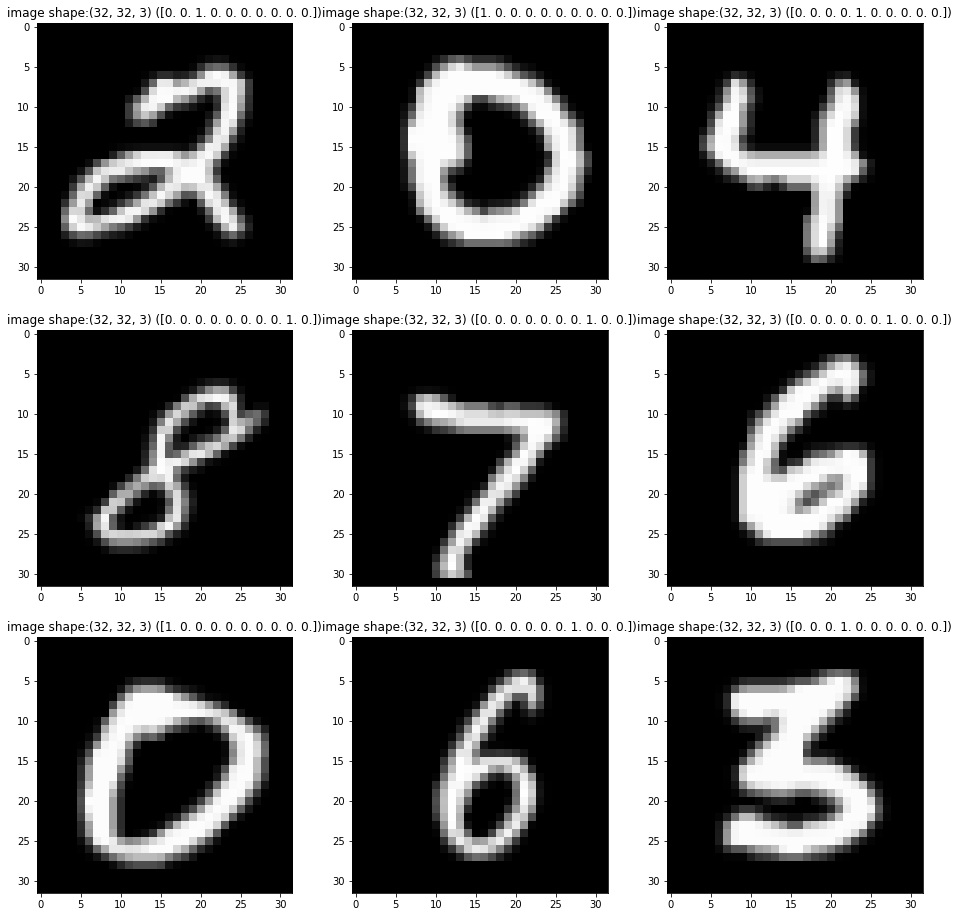

In [41]:
ds_train_resize_scale_one_hot= ds_train_resize_scale.map(one_hot)
ds_test_resize_scale_one_hot= ds_test_resize_scale.map(one_hot)
show_samples(ds_test_resize_scale_one_hot)

**Notice that:**
* There are **10 labels / classes** 
* Labels are now **one-hot encoded** 


### Prepare the data pipeline by setting batch size

In [42]:
ds_train_resize_scale_one_hot_batched=ds_train_resize_scale_one_hot.batch(64)
ds_test_resize_scale_one_hot_batched=ds_test_resize_scale_one_hot.batch(64)

### Create the classification model


In [43]:
inputs = keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

initializer = tf.keras.initializers.GlorotUniform(seed=42)
activation = tf.keras.activations.softmax # None  #  tf.keras.activations.sigmoid or softmax

outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation)(x) 
 
model = keras.Model(inputs, outputs)

**Pay attention**:
* The last layer has **number_of_classes (10) units**. Thus the output will support  **one-hot** encoding of the true (actual) label. 

* For the last layer, the activation function can be:
  * None 
  * sigmoid 
  * softmax
* When there is **no activation** function is used, we need to set `from_logits=True` **in cross-entropy functions** as we discussed above

### Compile the model

In [44]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(), # default from_logits=False
              metrics=[keras.metrics.CategoricalAccuracy()])

**IMPORTANT:** We need to use **keras.metrics.CategoricalAccuracy()** for **measuring** **the** **accuracy** since it calculates how often predictions matches **one-hot labels**. **DO NOT USE** just `metrics=['accuracy']` as a performance metric, as explained [in Part A!](https://kmkarakaya.medium.com/how-to-solve-classification-problems-in-deep-learning-with-tensorflow-keras-6e39c5b09501)  



---
### Try & See
You can try and see the performance of the model by using **combination of activation  and loss functions.**


Each epoch takes almost 15 seconds on Colab TPU accelerator.

In [45]:
model.fit(ds_train_resize_scale_one_hot_batched, validation_data=ds_test_resize_scale_one_hot_batched, epochs=20)

Epoch 1/20
94/94 [==============================] - 3s 22ms/step - loss: 2.1458 - categorical_accuracy: 0.2841 - val_loss: 1.3637 - val_categorical_accuracy: 0.6960
Epoch 2/20
94/94 [==============================] - 1s 13ms/step - loss: 1.2578 - categorical_accuracy: 0.7203 - val_loss: 1.0007 - val_categorical_accuracy: 0.7700
Epoch 3/20
94/94 [==============================] - 1s 13ms/step - loss: 0.9452 - categorical_accuracy: 0.7838 - val_loss: 0.8218 - val_categorical_accuracy: 0.8170
Epoch 4/20
94/94 [==============================] - 1s 13ms/step - loss: 0.7828 - categorical_accuracy: 0.8211 - val_loss: 0.7106 - val_categorical_accuracy: 0.8500
Epoch 5/20
94/94 [==============================] - 1s 13ms/step - loss: 0.6797 - categorical_accuracy: 0.8442 - val_loss: 0.6324 - val_categorical_accuracy: 0.8670
Epoch 6/20
94/94 [==============================] - 1s 14ms/step - loss: 0.6065 - categorical_accuracy: 0.8636 - val_loss: 0.5733 - val_categorical_accuracy: 0.8740
Epoch 7/20

In [46]:
ds= ds_test_resize_scale_one_hot
print("Test Accuracy: ", model.evaluate(ds.batch(batch_size=10))[1])
print("10 Sample predictions ")
predictions= model.predict(ds.batch(batch_size=10).take(1))
y=[]
for (pred,(a,b)) in zip(predictions,ds.take(10)):
  print("predicted: " , (pred), "Actual Label: "+str(b.numpy()) , " True" if (np.argmax(pred)==np.argmax(b.numpy())) else " False" )
  print()
  y.append(b.numpy())

100/100 [==============================] - 1s 6ms/step - loss: 0.2917 - categorical_accuracy: 0.9300
Test Accuracy:  0.9300000071525574
10 Sample predictions 
predicted:  [1.9556731e-03 3.5308425e-05 7.5961781e-01 3.0424668e-02 5.1526550e-02
 6.1237961e-02 2.1736654e-03 6.3268589e-03 6.7567535e-02 1.9133870e-02] Actual Label: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]  True

predicted:  [9.9030322e-01 7.5508825e-07 3.7850853e-04 1.0482117e-05 2.9154212e-06
 4.6265445e-04 3.4785511e-03 2.5551919e-05 3.3336622e-04 5.0040549e-03] Actual Label: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]  True

predicted:  [2.0553598e-04 1.8895212e-04 3.3390080e-03 1.6264344e-03 9.7731644e-01
 2.9302398e-03 6.0427433e-04 7.7113500e-03 4.0645222e-03 2.0131583e-03] Actual Label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]  True

predicted:  [2.7865969e-04 4.9618196e-05 1.3608298e-01 9.1951042e-03 1.1002642e-02
 1.4392880e-02 5.8454690e-03 4.7576425e-04 7.5770795e-01 6.4968966e-02] Actual Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]  True

predicted

---
## Obtained Results*:


| Activation | Loss | Accuracy |
| :- | -: | :-: |
| softmax | BinaryCrossentropy() |0.9060
| sigmoid | BinaryCrossentropy() |0.9060 
| None | BinaryCrossentropy(from_logits=True) | 0.9060
| **softmax**  | **CategoricalCrossentropy()** |**0.9300**
| **sigmoid** | **CategoricalCrossentropy()** | **0.9300**
| **None** | **CategoricalCrossentropy(from_logits=True)** | **0.9300**
| softmax | SparseCategoricalCrossentropy() | InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [64,10] and labels shape [640]
| sigmoid | SparseCategoricalCrossentropy() | InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [64,10] and labels shape [640]
| None | SparseCategoricalCrossentropy(from_logits=True) | InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [64,10] and labels shape [640]

.
* When you run this notebook, most probably you would not get the exact numbers rather you would observe very similar values due to stochastic nature of ANNs.


---
### **Why do SparseCategoricalCrossentropy loss functions generate errors?**



Because, for true labels we are using **one-hot encoding** and the last layer outputs **a vector of size 10**(number_of_classes). 

However, SparseCategoricalCrossentropy loss function expects integer numbers for true labels. Thus, SparseCategoricalCrossentropy loss function can ***NOT compute with one-hot vector!***

---
### **Why do Binary and Categorical cross-entropy loss functions with  lead to similar accuracy?**








I would like to remind you that when two loss functions are applied to the true labels that are encoded as **one-hot**, the calculated loss values are **very similar**. 
Thus, the model converges by using the loss function results and since both functions ***might*** generate similar loss values, the resulting trained models would have similar accuracy as seen above.

A simple example:


In [47]:
y_true=[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

# Assume last layer output is as:
y_pred_logit = tf.constant([[-20, -1.0, 4.5, 12.5, 74, 43.2, -58.4, 8.2, 99.9, -101]], dtype = tf.float32)
print("y_pred_logit:\n", y_pred_logit.numpy())

# and last layer activation function is softmax:
y_pred_softmax = tf.keras.activations.softmax(y_pred_logit)
print("\nsoftmax(y_pred) :\n", y_pred_softmax.numpy())

print("\ncategorical_crossentropy loss: ", tf.keras.losses.categorical_crossentropy
      (y_true, y_pred_softmax).numpy())
print("\nbinary_crossentropy loss: ", tf.keras.losses.binary_crossentropy
      (y_true, y_pred_softmax).numpy())

y_pred_logit:
 [[ -20.    -1.     4.5   12.5   74.    43.2  -58.4    8.2   99.9 -101. ]]

softmax(y_pred) :
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6464078e-12
  2.3741193e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]

categorical_crossentropy loss:  [25.900002]

binary_crossentropy loss:  [16.86246]


---
### **Why do Sigmoid and Softmax activation with Categorical cross-entropy loss function lead to the same accuracy?**




* Since we use **one-hot** encoding in true label encoding, sigmoid transforms all 10 numbers from the last layer to  floating numbers ranging from 0.0 to 1.0 but the sum of these 10 numbers **does not necessarily  equal to 1** (they are not probability distribution). 
* On the other hand, softmax transforms all 10 numbers from the last layer to  floating numbers ranging from 0.0 to 1.0 **and** the sum of these 10 numbers  **exactly  equals to 1.0**. 
* Normally, the Categorical cross-entropy loss function expects a probability distribution over the input values (when from_logit = False as default). 

* Even so, the  Categorical cross-entropy loss functions can consume sigmoid outputs and generate similar loss values.

A simple example:

In [48]:
y_true=[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

# Assume last layer output is as:
y_pred_logit = tf.constant([[-20, -1.0, 4.5, 12.5, 74, 43.2, -58.4, 8.2, 99.9, -101]], dtype = tf.float32)
print("y_pred_logit:\n", y_pred_logit.numpy())

# and last layer activation function is softmax:
y_pred_softmax = tf.keras.activations.softmax(y_pred_logit)
print("\nsoftmax(y_pred_logit) :\n", y_pred_softmax.numpy())
print("categorical_crossentropy(y_true, y_pred_softmax) loss:\n", 
      tf.keras.losses.categorical_crossentropy
      (y_true, y_pred_softmax).numpy())

# and last layer activation function is sigmoid:
y_pred_sigmoid = tf.keras.activations.sigmoid(y_pred_logit)
print("\nsigmoid(y_pred_logit) :\n", y_pred_sigmoid.numpy())
print("categorical_crossentropy(y_true, y_pred_sigmoid) loss:\n", 
      tf.keras.losses.categorical_crossentropy
      (y_true, y_pred_sigmoid).numpy())

y_pred_logit:
 [[ -20.    -1.     4.5   12.5   74.    43.2  -58.4    8.2   99.9 -101. ]]

softmax(y_pred_logit) :
 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6464078e-12
  2.3741193e-25 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00]]
categorical_crossentropy(y_true, y_pred_softmax) loss:
 [25.900002]

sigmoid(y_pred_logit) :
 [[2.0611535e-09 2.6894143e-01 9.8901308e-01 9.9999630e-01 1.0000000e+00
  1.0000000e+00 4.3371215e-26 9.9972540e-01 1.0000000e+00 0.0000000e+00]]
categorical_crossentropy(y_true, y_pred_sigmoid) loss:
 [25.900002]


As seen above, when the last layer generates some logits, s***igmoid and softmax functions produce different results***.

However, when we apply **categorical_crossentropy** loss function on their results, ***the computed loss is exactly the same***.

---
### Summary

According to the above experiment results, if the task is **multi-class classification** and true (actual) labels are encoded as a **one-hot**, we might have 2 options:
* Option A
  * activation = **None**
  * loss = **CategoricalCrossentropy(from_logits=True)**
  * accuracy metric= **CategoricalAccuracy()**
* Option B
  * activation = **sigmoid or softmax** 
  * loss =**CategoricalCrossentropy()** 
  * accuracy metric= **CategoricalAccuracy()**






# Multi-Class Classification Summary

In a nut shel, in a **multi-class** classification 
* We can use **integer numbers** or **one-hot encoding** to encode the **true** classes / labels 
*  ***The correct accuracy metric*** depends on **the selected true label encoding**
* Last layer activation function could be **Sigmoid, Softmax or None**
* ***The correct loss function*** should be decided according to **the selected true label encoding**

So the summary of the experiments are below:

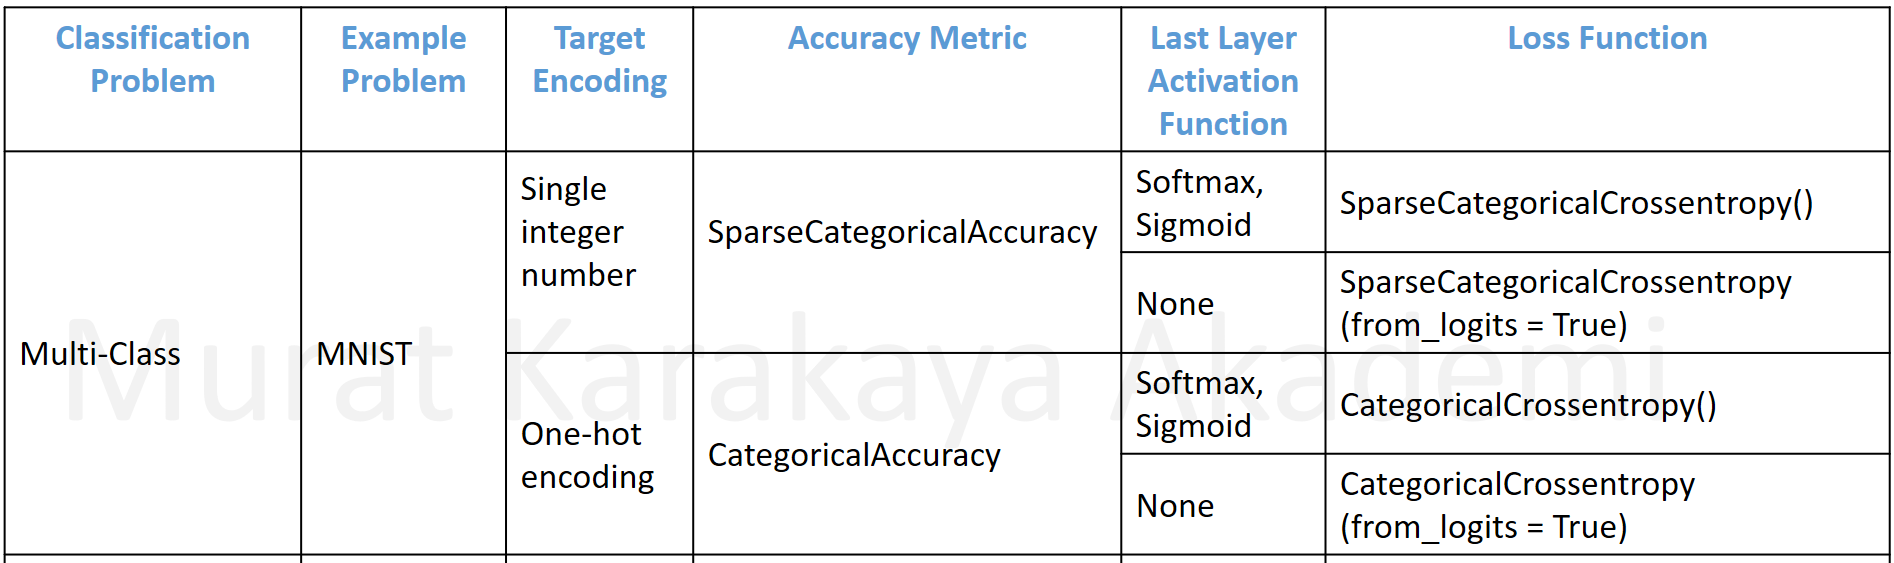

#Next Part: Multi-Label classification 